# Dynamax Binary GLM-HMM Model Tutorial

Written by Jess Breda 

This notebook investigates how to use the `LogisticRegressionHMM` class in the Dynamax State Space Library. 

Information and resources used to create this notebook came from:
* Dynamax [HMM Inference Example](https://probml.github.io/dynamax/notebooks/hmm/casino_hmm_inference.html)
* Dynamax [HMM Learning Example](https://probml.github.io/dynamax/notebooks/hmm/casino_hmm_learning.html)
* Dynamax [docs](https://probml.github.io/dynamax/api.html#dynamax.hidden_markov_model.LogisticRegressionHMM)
* Ashwood 2020 [tutorial using SMM](https://github.com/zashwood/ssm/blob/master/notebooks/2b%20Input%20Driven%20Observations%20(GLM-HMM).ipynb) (Dynamax pre jax)


## 1. Set up

In [3]:

import jax.numpy as jnp
import jax.random as jr
from dynamax.hidden_markov_model import LogisticRegressionHMM

from functools import partial
from jax import vmap
import optax


from multiglm.utils.dynamax_utils import *
import seaborn as sns
sns.set_context("talk")
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Input Driven Observations

Let's start by making out "true" model observations. We will use a 2 state model that has 2 features (e.g. stimulus a value, stimulus b value). Note the bias term is not included in the input dimensions. This model will have a "sticky" transition matrix with high values on the diagonal, as commonly found in 2AFC tasks.

Dynamax can do a lot under the hood. In initialize, by not providing a transition matrix ($A$), initial state probabilities ($\pi$), emission weights ($w$) or biases ($b$), the model uses a "prior" method to sample them. You can also use `method="kmeans"` as described in the [docs](https://probml.github.io/dynamax/api.html#dynamax.hidden_markov_model.LogisticRegressionHMM.initialize), or manually define these parameters at initialization. 

I have found that randomly initialized weights are difficult to recover. So, I will initialized two models to demonstrate this.

### 2a. Initialize random and PWM generative GLM-HMM

In [4]:
num_states = 3
input_dim = 2
rand_glmhmm = LogisticRegressionHMM(
    num_states=num_states, input_dim=input_dim, transition_matrix_stickiness=10
)
rand_params, _ = rand_glmhmm.initialize(key=jr.PRNGKey(19))

print_binary_hmm_params(rand_params)

Model has 3 states with initial probabilities:
  [0.3820482  0.5746822  0.04326962]

Transition_matrix:
 [[0.89604163 0.05495027 0.04900808]
 [0.06233016 0.7107719  0.22689798]
 [0.01297612 0.09862156 0.8884022 ]]

Emissions have 2 features with weights:
 [[-0.0058693   0.00170114]
 [-0.0070824  -0.0108016 ]
 [ 0.00211514 -0.01399114]]

Emissions have biases:
 [0.20212574 0.0766184  0.00599132]


In [5]:
weights = jnp.array([[2.5, -2.5], [-0.5, 0.5], [0.1, 3]])
baises = jnp.array([0.1, -1, 0.7])

glmhmm = LogisticRegressionHMM(
    num_states=num_states, input_dim=input_dim, transition_matrix_stickiness=10
)
params, _ = glmhmm.initialize(
    key=jr.PRNGKey(19), emission_weights=weights, emission_biases=baises
)

print_binary_hmm_params(params)

Model has 3 states with initial probabilities:
  [0.3820482  0.5746822  0.04326962]

Transition_matrix:
 [[0.89604163 0.05495027 0.04900808]
 [0.06233016 0.7107719  0.22689798]
 [0.01297612 0.09862156 0.8884022 ]]

Emissions have 2 features with weights:
 [[ 2.5 -2.5]
 [-0.5  0.5]
 [ 0.1  3. ]]

Emissions have biases:
 [ 0.1 -1.   0.7]


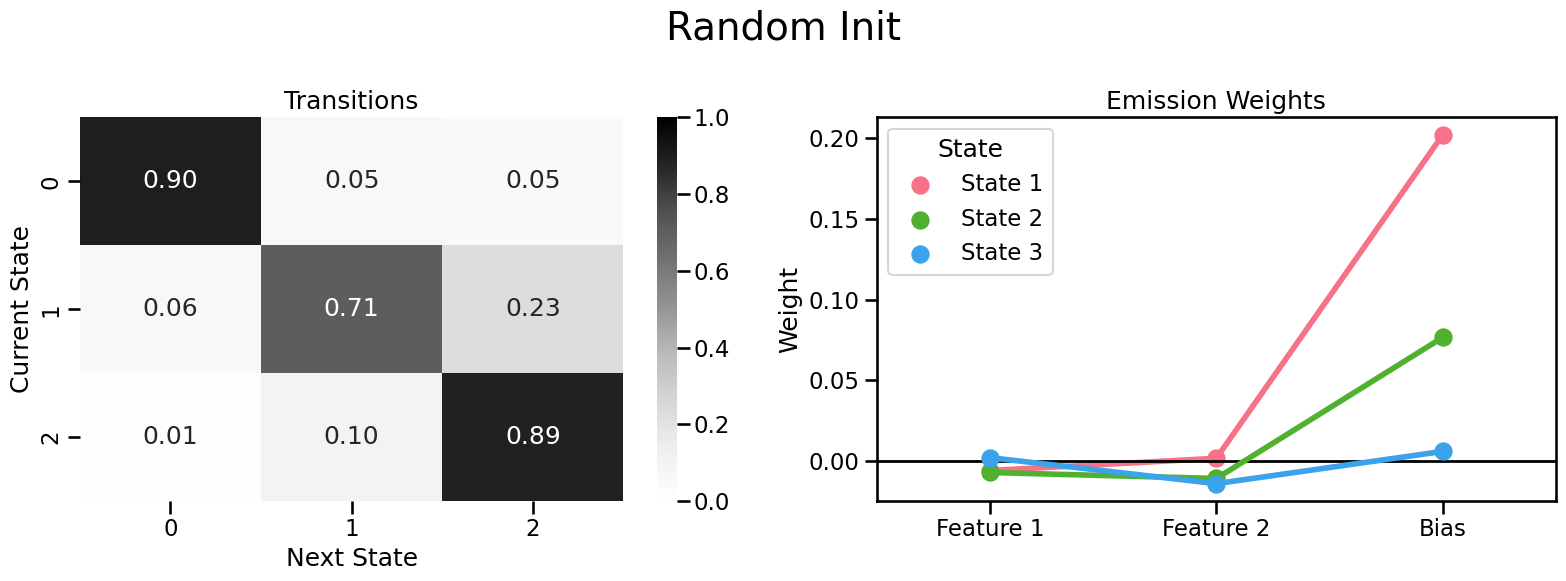

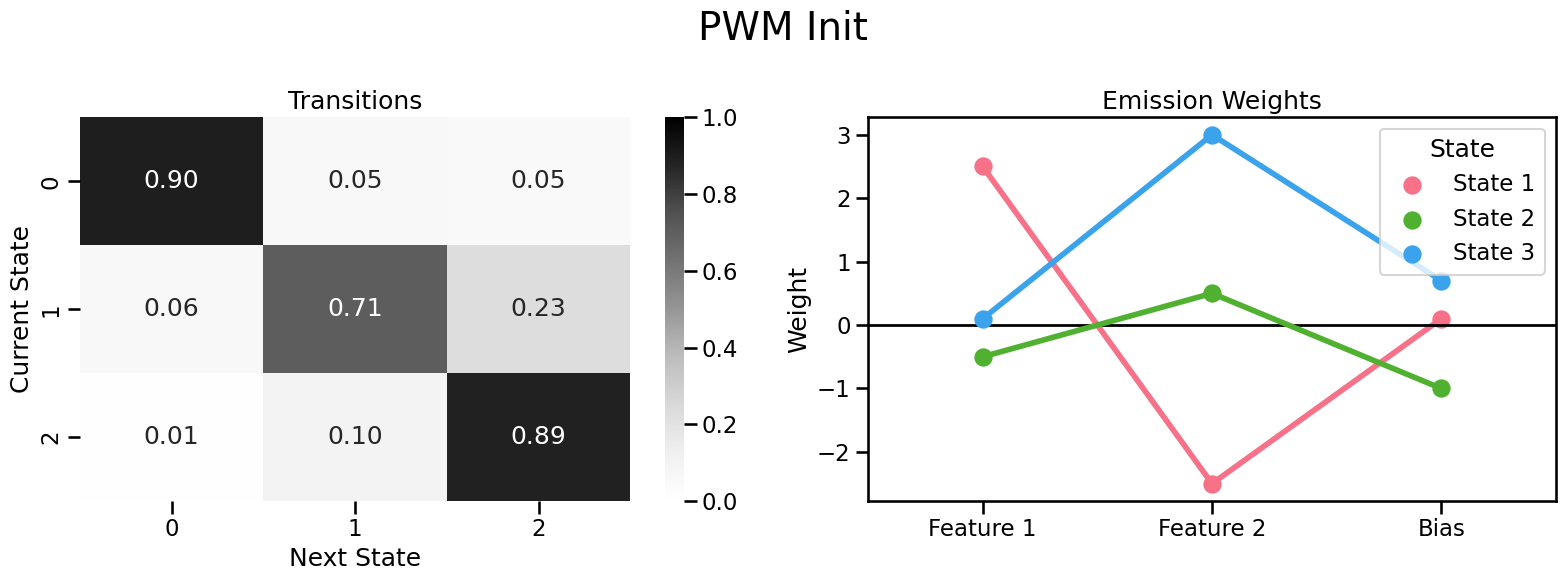

In [6]:
plot_binary_hmm_params(rand_params, plot_bias=True, title="Random Init")
plot_binary_hmm_params(params, plot_bias=True, title="PWM Init")


### 2b. Create inputs

Now we have our true model parameters of the transition matrix, initial state probabilities, weights and biases ($A$, $\pi$, $w$, $b$), as plotted above. 

Given these parameters, let's simulate states and emissions. To do this, we need to also provide the model with inputs ($X$). Although the `ssm.sample()` method says this is optional, for regressions methods this is a required input. This is because emissions are drawn from a Bernoulli distribution of the logits  as seen in `logreg_hmm.py`.

```   
def distribution(self, params, state, inputs):
        logits = params.weights[state] @ inputs + params.biases[state]
        return tfd.Bernoulli(logits=logits)
```

In [7]:
# Generate inputs
num_timesteps = 10000
key = jr.PRNGKey(19)
key1, key2 = jr.split(key)
inputs = jr.normal(key1, shape=(num_timesteps, input_dim))

print(f"first 5 inputs:\n {inputs[0:5, 0:5]}")

first 5 inputs:
 [[-0.2540664  -0.37408397]
 [ 0.07728613  1.638784  ]
 [-1.1059357   0.39131725]
 [ 0.37532523  1.6010314 ]
 [ 0.11666454  0.40866223]]


### 2c. Simulate states and emissions from generative model

Now we can use the `.sample()` method to generate our true states and emissions. We will also calculate the true log likelihood of this model.

In [8]:
# sample true states and emissions
rand_true_states, rand_emissions = rand_glmhmm.sample(
    rand_params,
    key2,
    num_timesteps=num_timesteps,
    inputs=inputs,
)

# sample true states and emissions
true_states, emissions = glmhmm.sample(
    params,
    key2,
    num_timesteps=num_timesteps,
    inputs=inputs,
)

In [11]:
true_ll = glmhmm.log_prob(params, true_states, emissions, inputs)
print(f"True joint log probs of pwm init: {true_ll:.2f}")

rand_true_ll = rand_glmhmm.log_prob(
    rand_params, rand_true_states, rand_emissions, inputs
)
print(f"True joint log probs of random init: {rand_true_ll:.2f}")

True joint log probs of pwm init: -8793.94
True joint log probs of random init: -11760.64


## 3. Fit GLM-HMM and perform recovery analysis

### 3a Initialize fitting GLM-HMM

Now, let's generate a new glm-hmm object for fitting. Will will initialize random parameters. The [property](https://probml.github.io/dynamax/api.html#dynamax.hidden_markov_model.HMMPropertySet) object is necessary for model fitting, and  among other things, allows you to specify which parameters should be learned.

In [12]:
key = jr.PRNGKey(0)

glmhmm_to_fit = LogisticRegressionHMM(
    num_states=num_states,
    input_dim=input_dim,
    transition_matrix_stickiness=10,
)
em_params, em_param_props = glmhmm_to_fit.initialize(key)

In [13]:
print_binary_hmm_params(em_params)

Model has 3 states with initial probabilities:
  [0.49839333 0.4080342  0.09357239]

Transition_matrix:
 [[0.8323941  0.05983524 0.10777071]
 [0.0960795  0.8553235  0.04859692]
 [0.05061918 0.0967057  0.85267514]]

Emissions have 2 features with weights:
 [[-0.00943909  0.00377024]
 [ 0.00113326  0.01152059]
 [ 0.00627734 -0.00384544]]

Emissions have biases:
 [-0.560632    0.17701872 -0.04583511]


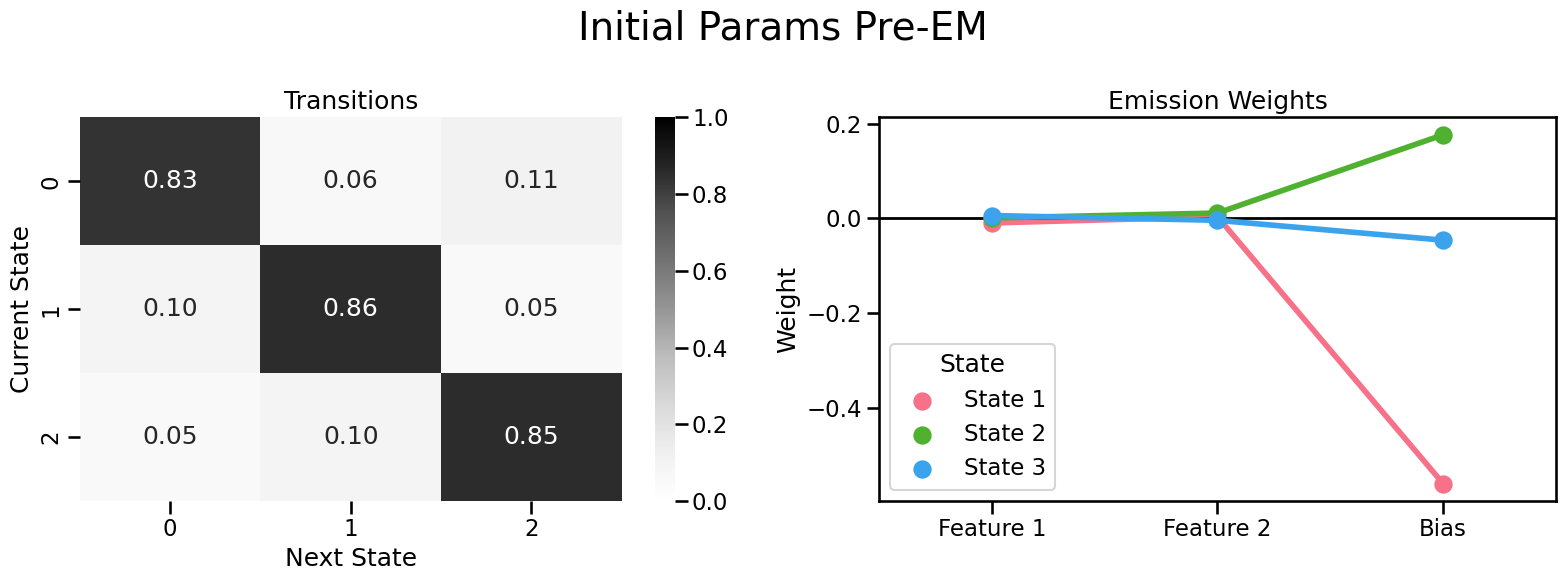

In [14]:
plot_binary_hmm_params(em_params, plot_bias=True, title="Initial Params Pre-EM")

### 3b. Fit model using Maximum Likelihood Estimation

#### 3b1. Using PWM init for ground truth

Let's use the `.fit_em()` [method](https://probml.github.io/dynamax/api.html#dynamax.ssm.SSM.fit_em) to perform parameter estimation with our generated inputs and emissions. 

In [15]:
em_params, log_probs = glmhmm_to_fit.fit_em(
    em_params, em_param_props, emissions=emissions, inputs=inputs, num_iters=200
)

In [16]:
fit_ll = glmhmm_to_fit.log_prob(em_params, true_states, emissions, inputs)

print(f"Fit joint log probs w/ PWM init: {fit_ll:.2f}")
print(f"True joint log probs: {true_ll:.2f}")

Fit joint log probs w/ PWM init: -13641.55
True joint log probs: -8793.94


Text(0, 0.5, 'Joint Log Probability')

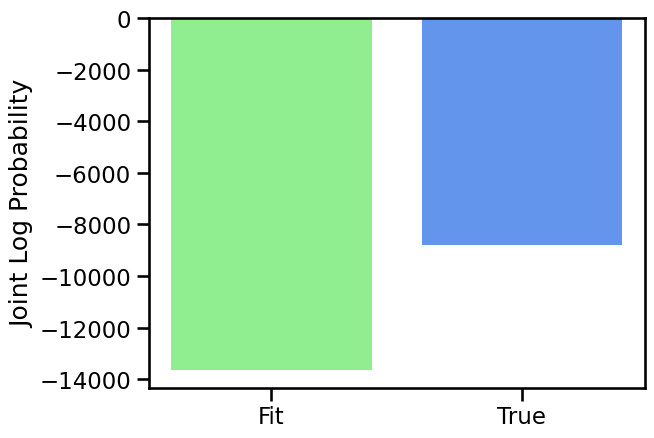

In [17]:
plt.bar(
    x=["Fit", "True"], height=[fit_ll, true_ll], color=["lightgreen", "cornflowerblue"]
)
plt.ylabel("Joint Log Probability")

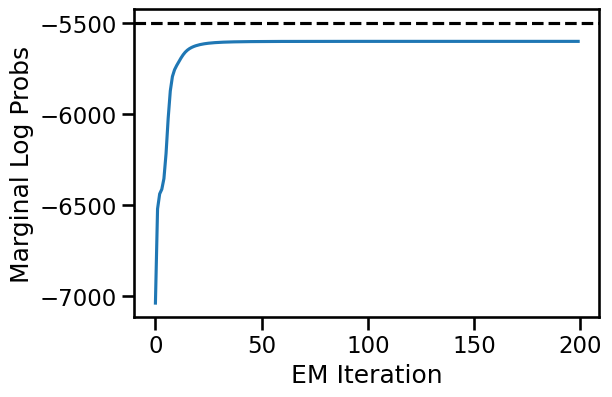

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(log_probs)
ax.axhline(
    glmhmm.marginal_log_prob(
        params,
        emissions,
        inputs,
    ),
    color="k",
    ls="--",
)
_ = ax.set(xlabel="EM Iteration", ylabel="Marginal Log Probs")

It looks like we are getting stuck in a local minimum here- will need to work on this. Multiple instantiations of the model can help with this.

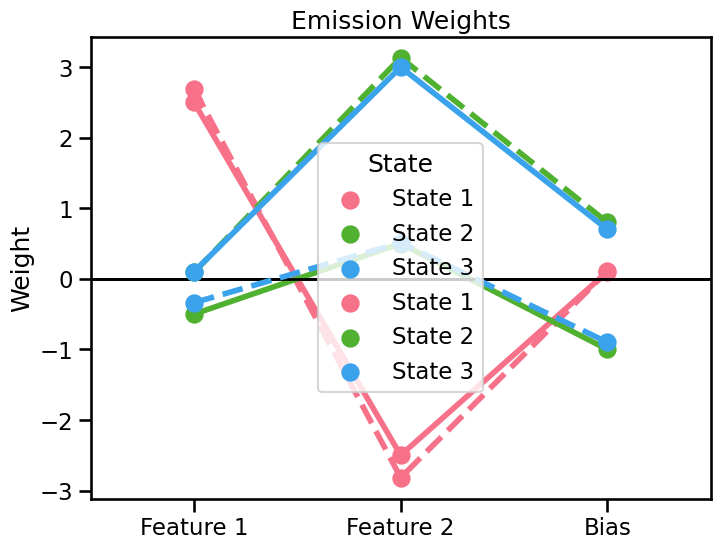

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_binary_emission_weights(params, plot_bias=True, ax=ax)
plot_binary_emission_weights(em_params, plot_bias=True, ax=ax, linestyles="--")

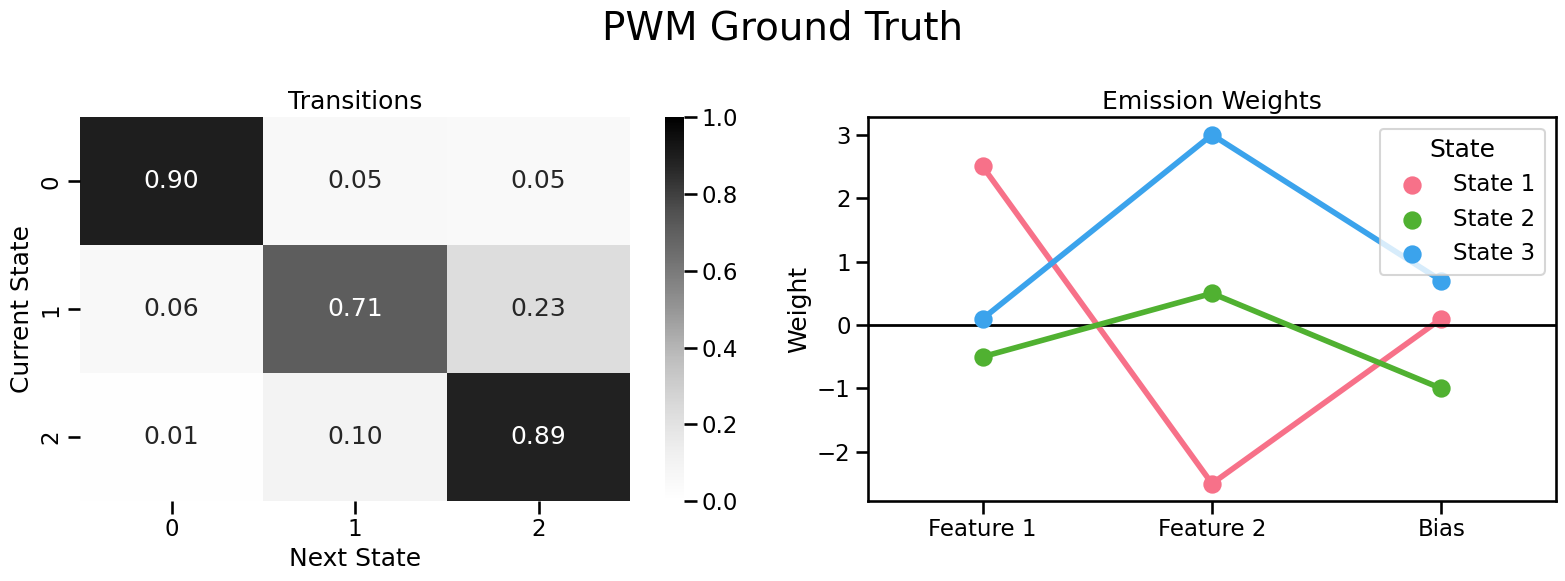

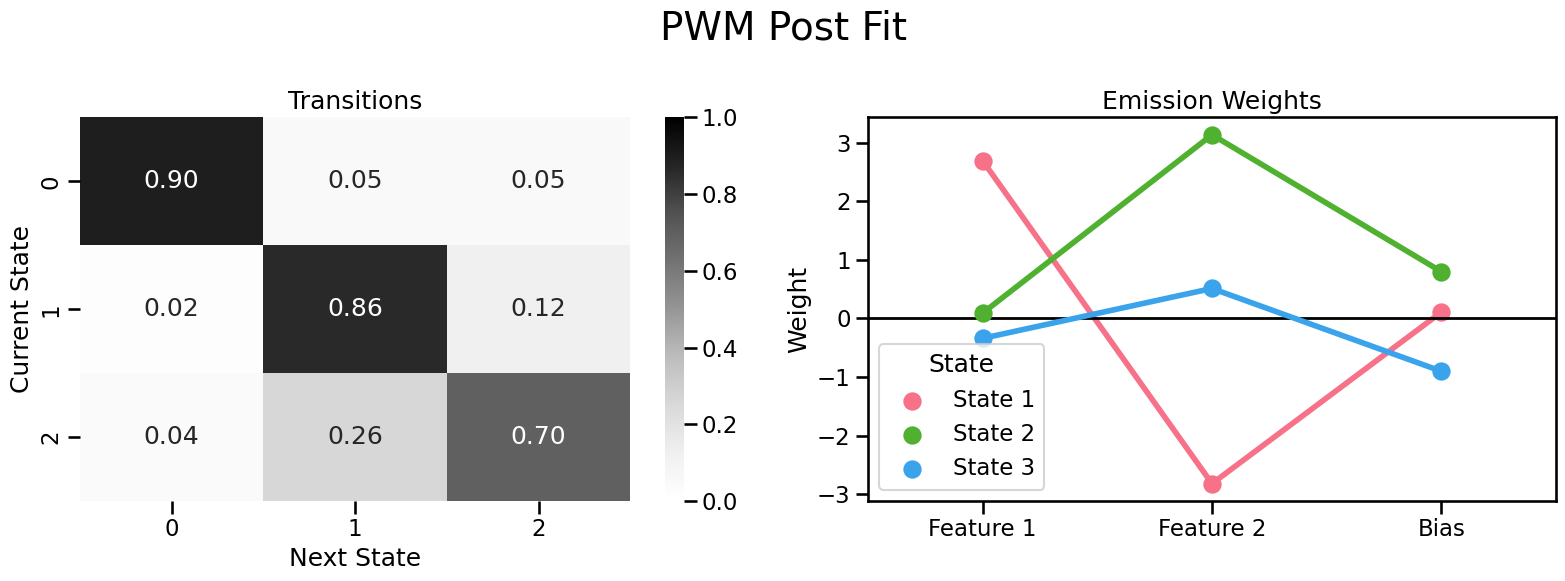

In [21]:
plot_binary_hmm_params(params, plot_bias=True, title="PWM Ground Truth")
plot_binary_hmm_params(em_params, plot_bias=True, title="PWM Post Fit")

#### 3b1. Using Random init for ground truth

Let's repeat the same things above but with randomly initialized weights and biases.


In [22]:
rem_params, r_log_probs = glmhmm_to_fit.fit_em(
    em_params, em_param_props, emissions=rand_emissions, inputs=inputs, num_iters=200
)

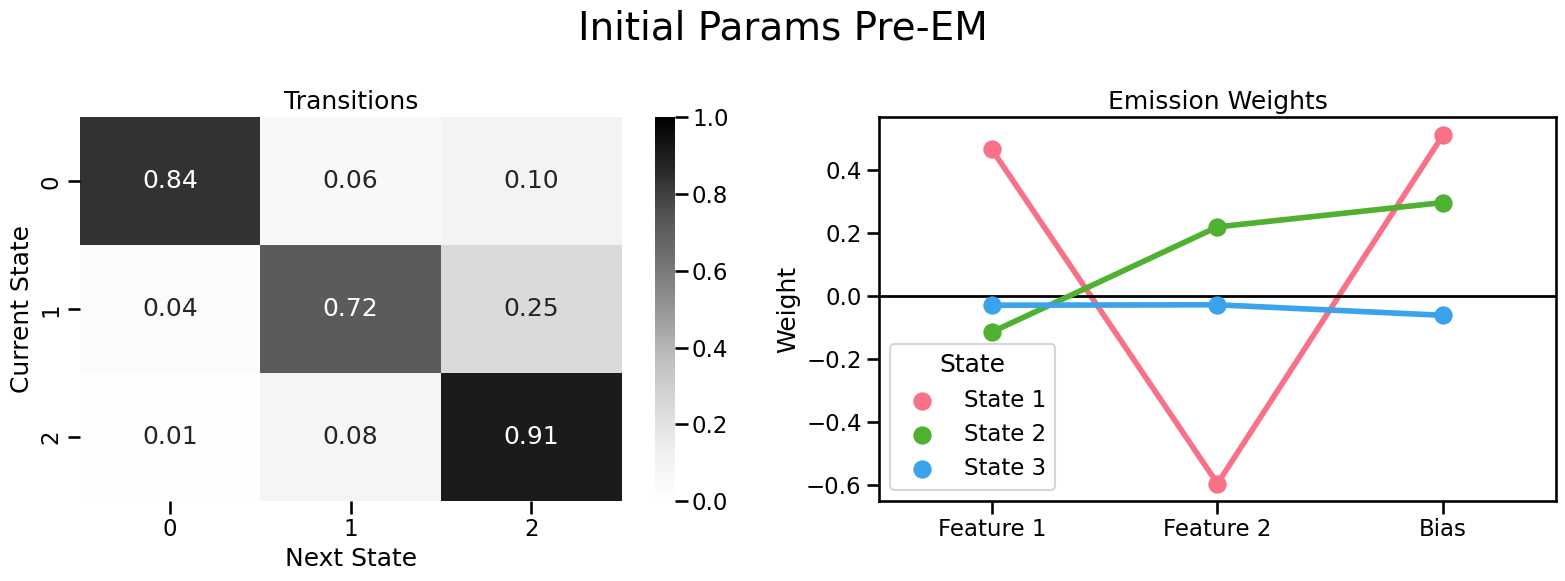

In [23]:
plot_binary_hmm_params(rem_params, plot_bias=True, title="Initial Params Pre-EM")

In [24]:
rand_fit_ll = glmhmm_to_fit.log_prob(
    em_params, rand_true_states, rand_emissions, inputs
)

print(f"Fit joint log probs: {rand_fit_ll:.2f}")
print(f"True random joint log probs: {rand_true_ll:.2f}")

Fit joint log probs: -17264.63
True random joint log probs: -11760.64


Text(0, 0.5, 'Joint Log Probability')

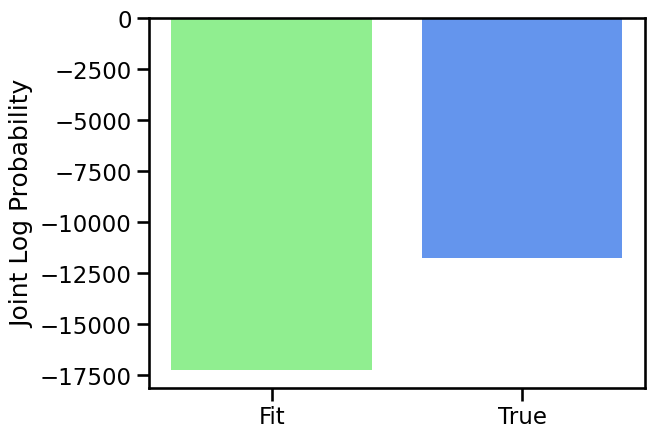

In [25]:
plt.bar(
    x=["Fit", "True"],
    height=[rand_fit_ll, rand_true_ll],
    color=["lightgreen", "cornflowerblue"],
)
plt.ylabel("Joint Log Probability")

compute log marginal likelihood of observations $$\log \sum_{z_{1:T}} p(y_{1:T}, z_{1:T} \mid \theta)$$.


*  params: model parameters $\theta$

* state: current latent state $z_t$

*   inputs: current inputs $u_t$

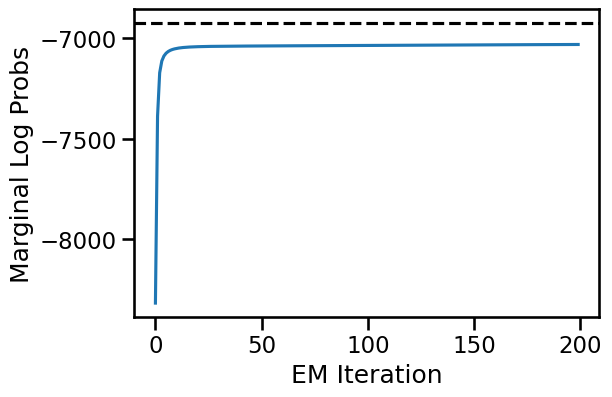

In [26]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(r_log_probs)
ax.axhline(
    rand_glmhmm.marginal_log_prob(
        rem_params,
        rand_emissions,
        inputs,
    ),
    color="k",
    ls="--",
)
_ = ax.set(xlabel="EM Iteration", ylabel="Marginal Log Probs")

Again, appears to be getting stuck in a local minimum.

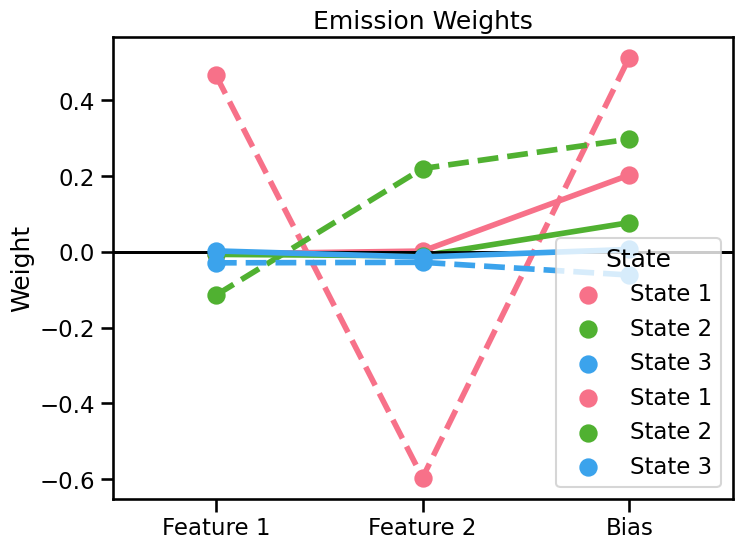

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_binary_emission_weights(rand_params, plot_bias=True, ax=ax)
plot_binary_emission_weights(rem_params, plot_bias=True, ax=ax, linestyles="--")

Weight recovery is not as good with randomly initialized ground truth. The transition matrix is pretty close though.

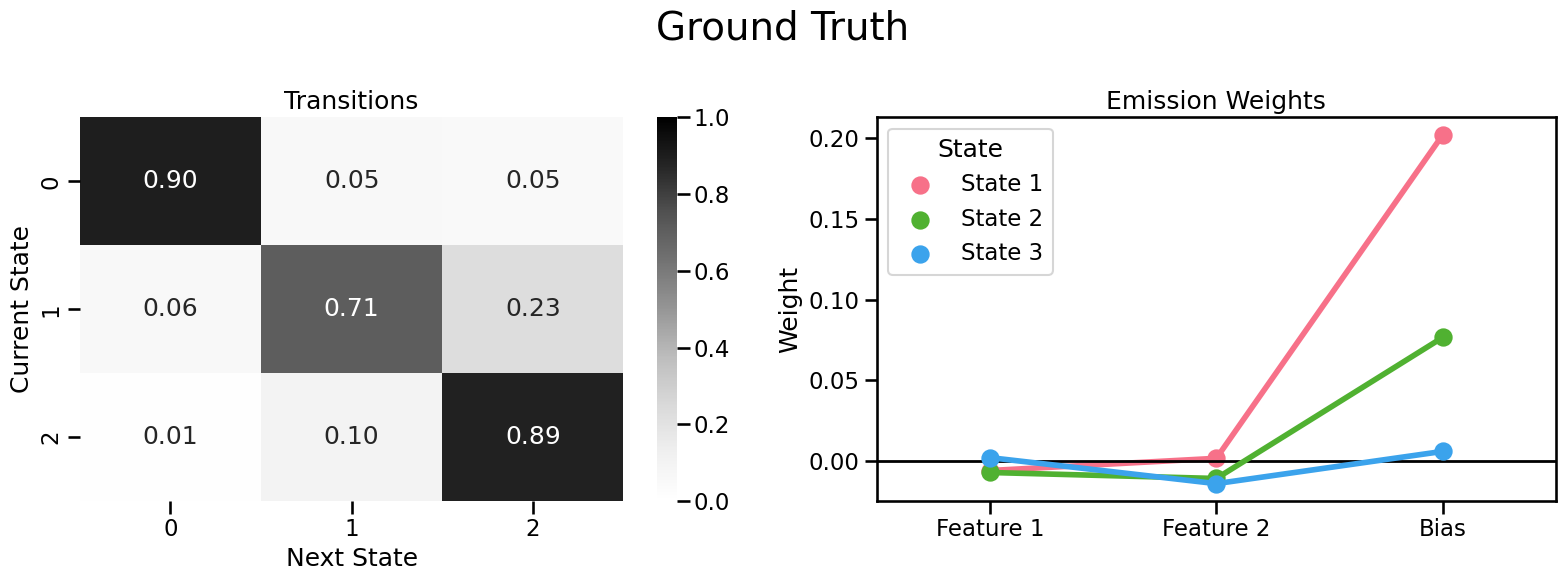

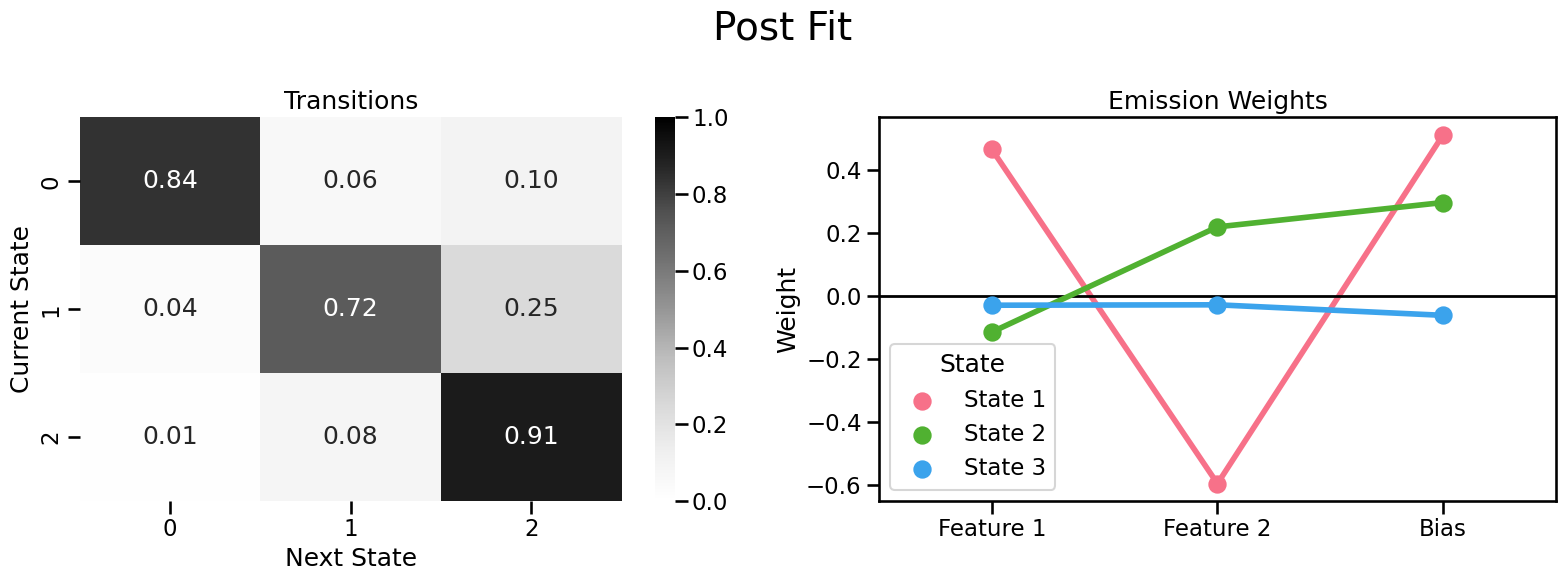

In [27]:
plot_binary_hmm_params(rand_params, plot_bias=True, title="Ground Truth")
plot_binary_hmm_params(rem_params, plot_bias=True, title="Post Fit")

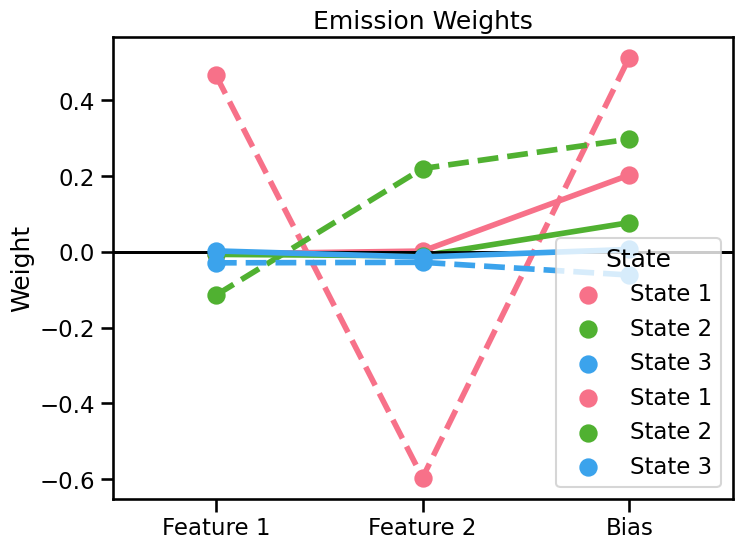

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_binary_emission_weights(rand_params, plot_bias=True, ax=ax)
plot_binary_emission_weights(rem_params, plot_bias=True, ax=ax, linestyles="--")

# Post Meeting Summary:

1. Good starting points for model

2. Log probs is not the log likelihood we care about (SMM and Dynamax differ in this syntax), we want the marignal log liklihood (probability of data integrating out the states). This is what EM is trying to maximize.

3. Focus on just 2 states

4. Init the fitting model with true parameters and ensure the fit ll is better than truth

